# IMPORT

In [21]:
import pandas as pd

In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# DATA LOAD

In [70]:
rtn_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [71]:
df3=rtn_df[['Date','코스피']]
df3.Date=pd.to_datetime(df3.Date)
df3=df3.set_index('Date')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [72]:
rtn_df['Date']=pd.to_datetime(rtn_df['Date'])
rtn_df=rtn_df.set_index('Date')

In [73]:
rtn_df=rtn_df[rtn_df['상승']==0]
rtn_df=rtn_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]
rtn_df

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
Date,,,,,,,
2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493
2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176
2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103
2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103
2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212
...,...,...,...,...,...,...,...
2022-05-04,0.000084,-0.000864,-0.001079,0.009819,0.030728,0.011425,0.014217
2022-05-05,0.000000,0.000000,0.000000,-0.004196,-0.005292,-0.027030,-0.033019
2022-05-06,0.000109,0.001001,-0.012424,0.001961,0.001061,-0.011940,-0.016993


In [74]:
rtn_df_train=rtn_df.loc[:'2021-08-31']
rtn_df_test=rtn_df.loc['2021-09-01':'2022-05-10']

In [75]:
rtn_df_train

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
Date,,,,,,,
2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493
2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176
2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103
2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103
2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212
...,...,...,...,...,...,...,...
2020-06-24,0.000044,0.000002,0.014103,-0.002368,-0.025318,-0.028902,-0.028392
2020-06-25,0.000025,0.000145,-0.022996,-0.001186,0.009057,0.012691,0.029151
2020-06-26,0.000017,0.000046,0.010492,0.004737,-0.012371,-0.019380,-0.024478


# 학습 데이터 생성

In [99]:
# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
#
# 1. 학습 데이터와 평가 데이터 생성 모듈.
#
# 참고 : https://blog.naver.com/chunjein/222492404960
#        https://blog.naver.com/chunjein/222494724278
#        https://blog.naver.com/chunjein/222496640766
#
# 2021.08.27   blog.naver.com/chunjein (조성현)
# ------------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle


N_STOCKS = 7  # 포트폴리오를 구성할 주식 종목 개수
N_TIME = 20    # look back window size
N_FUTURE = 20  # 미래 20 기간의 최적 포트폴리오를 추정할 예정이다.


# 1. 학습과 performance-test에 사용할 데이터를 생성한다.
# --------------------------------------------------
# 수익률 sequence 데이터를 생성한다.
def make_sequence(x):
    T = N_TIME + N_FUTURE
    x_seq = np.expand_dims(np.array(x.iloc[0:T, :]), 0)
    
    for i in range(1, len(x) - T + 1):
        d = np.expand_dims(np.array(x.iloc[i:(i+T), :]), 0)
        x_seq = np.concatenate((x_seq, d))
        
    return x_seq

# 학습 데이터와 시험 데이터를 생성한다. 시험 데이터는 향후 performance test용으로
# 사용한다. 학습 데이터 80%, 시험 데이터 20%
n = int(rtn_df.shape[0] * 0.9)
rtn_train = make_sequence(rtn_df_train)
rtn_test = make_sequence(rtn_df_test)   # 이 데이터는 학습에 사용하지 않는다.
 
print("# 수익률 sequence 데이터를 생성했습니다.")

# 2. 학습에 사용할 데이터를 생성한다.
# -------------------------------
# 다음 기간 (N_FUTURE 기간)을 학습/예측하도록 데이터를 구성한다.
xc_train = np.array([x[:N_TIME] for x in rtn_train])
xf_train = np.array([x[-N_FUTURE:] for x in rtn_train])
                     
xc_test = np.array([x[:N_TIME] for x in rtn_test])
xf_test = np.array([x[-N_FUTURE:] for x in rtn_test])

# 4.performace_test.py에서 성과 차트를 그릴 때 x축 인덱스로 사용하기 위해
# xf_test[0][0] 위치부터 끝까지 날짜를 기록해 둔다.
test_date = rtn_df_test[N_TIME:].index


# 수익률 sequence 데이터를 생성했습니다.


## 데이터셋 나눠서 만들기(상승)


In [83]:
df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')

In [84]:
df=df[df['상승']==0]

In [85]:
df=df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [35]:
up_2006=df.loc['2006-10-02':'2007-10-31']
up_2009=df.loc['2009-01-02':'2010-01-29']
up_2012=df.loc['2012-03-01':'2013-09-30']
up_2014=df.loc['2014-09-01':'2015-05-29']
up_2015=df.loc['2015-10-01':'2016-01-29']
up_2016=df.loc['2016-05-02':'2017-06-30']
up_2019=df.loc['2019-12-02':'2020-03-31']
#up_2020=df.loc['2020-07-01':'2021-08-31']

In [100]:
#기간별 잘라서 train셋 만들기
T = N_TIME + N_FUTURE
x_seq = np.expand_dims(np.array(up_2006.iloc[0:T, :]), 0)

for i in range(1, len(up_2006) - T + 1):
    d = np.expand_dims(np.array(up_2006.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2009) - T + 1):
    d = np.expand_dims(np.array(up_2009.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2012) - T + 1):
    d = np.expand_dims(np.array(up_2012.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2014) - T + 1):
    d = np.expand_dims(np.array(up_2014.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2015) - T + 1):
    d = np.expand_dims(np.array(up_2015.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2016) - T + 1):
    d = np.expand_dims(np.array(up_2016.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(up_2019) - T + 1):
    d = np.expand_dims(np.array(up_2019.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
#for i in range(0, len(up_2020) - T + 1):
    #d = np.expand_dims(np.array(up_2020.iloc[i:(i+T), :]), 0)
    #x_seq = np.concatenate((x_seq, d))

#  데이터셋 나눠서 만들기(하강)


In [95]:
down_2006=df.loc['2006-03-01':'2006-09-29']
down_2007=df.loc['2007-11-01':'2008-12-31']
down_2010=df.loc['2010-02-01':'2012-02-29']
down_2013=df.loc['2013-10-01':'2014-08-29']
down_2015=df.loc['2015-06-01':'2015-09-30']
down_2016=df.loc['2016-02-01':'2016-04-29']
down_2017=df.loc['2017-07-03':'2019-11-29']
down_2020=df.loc['2020-04-01':'2020-06-30']
#down_2021=df.loc['2021-09-01':'2022-05-10']

In [101]:
#기간별 잘라서 train셋 만들기
T = N_TIME + N_FUTURE
x_seq = np.expand_dims(np.array(down_2006.iloc[0:T, :]), 0)

for i in range(1, len(down_2006) - T + 1):
    d = np.expand_dims(np.array(down_2006.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2007) - T + 1):
    d = np.expand_dims(np.array(down_2007.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2010) - T + 1):
    d = np.expand_dims(np.array(down_2010.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2013) - T + 1):
    d = np.expand_dims(np.array(down_2013.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2015) - T + 1):
    d = np.expand_dims(np.array(down_2015.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2016) - T + 1):
    d = np.expand_dims(np.array(down_2016.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2017) - T + 1):
    d = np.expand_dims(np.array(down_2017.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2020) - T + 1):
    d = np.expand_dims(np.array(down_2020.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(down_2021) - T + 1):
#     d = np.expand_dims(np.array(down_2021.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))

# rtn_train 구성하기

In [102]:
# rtn_train 값에 기간별로 자른 값 집어넣기
rtn_train = x_seq
xc_train = np.array([x[:N_TIME] for x in rtn_train])
xf_train = np.array([x[-N_FUTURE:] for x in rtn_train])

# 모델 학습

In [38]:
# random seed 값 고정
np.random.seed(3)
tf.random.set_seed(3)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7)                 420       
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 activation_6 (Activation)   (None, 7)                 0         
                                                                 
Total params: 476
Trainable params: 476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
28/28 [==============================] - 3s 32ms/step - loss: 0.1207 - val_loss: -0.9947
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 0.0913 - val_loss: -0.9953
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.0964 - val_loss: -0.9958
Epoch 4/1000
28

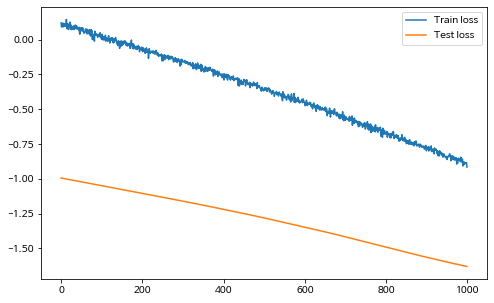

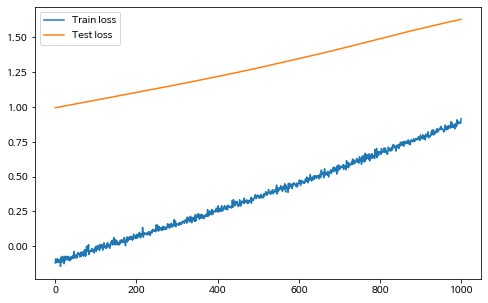

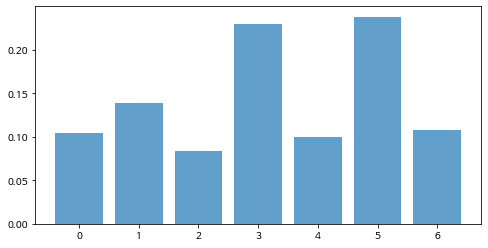

In [103]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') *100
xf_train = xf_train.astype('float32') *100
xc_test = xc_test.astype('float32') *100
xf_test = xf_test.astype('float32') *100

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
#xc_train, xf_train = shuffle(xc_train, xf_train)

# Markowitz Network를 생성한다.
# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
REG_CONST = 0.0
SAVE_MODEL = 'data/3-1.MPN_LSTM.h5'

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# Markowitz Network에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)   # W = (None, 1, 50)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2) # R = (None, 50, 1)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_sum(objective, axis=0)


lstm = LSTM( units = 7, # units의 값은 layer 통일이 제일 효과적이다.
             input_shape=(N_TIME, N_STOCKS),  #(4980, 20, 5)  --> (20,5),    
             dropout=0.0,
             recurrent_dropout=0.0,
             return_sequences=False
      )
model = Sequential()
model.add( lstm )
model.add( Dense(N_STOCKS, activation='tanh') )
model.add(Activation('softmax'))


# 마코비츠의 최적 weights
with tf.device("/device:GPU:0"):
    #y_output = Activation('softmax')(y_output)

    
    model.compile(loss = markowitz_objective, 
                optimizer = Adam(learning_rate = 1e-5),
                )
    stop = EarlyStopping(patience=10, monitor='val_loss')

    model.summary()

    # MPN을 학습하고 결과를 저장한다.
    hist = model.fit(xc_train, xf_train, epochs=1000, batch_size = 64, 
                     callbacks=[stop],
                    validation_data = (xc_test, xf_test))
    #model.save(SAVE_MODEL)

# loss trajectory를 확인한다.
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.negative(hist.history['loss']), label='Train loss')
plt.plot(np.negative(hist.history['val_loss']), label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 확인용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()
    
check_w(0)


# 백테스팅

In [104]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 모델을 가져온다.
lstm_model = model

# MPN을 이용해서 백 테스트를 수행한다.
# --------------------------------
lstm_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_hist_lstm = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # LSTM으로 W를 추정한다.
    x = xc_test[i][np.newaxis,:, :]
    w_lstm = lstm_model.predict(x)[0]
    w_hist_lstm.append(w_lstm)
    
    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i]/100, axis = 0)
    
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    lstm_value.append(lstm_value[-1] * np.exp(np.dot(w_lstm, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))

print('\nBack test를 완료했습니다.')



Back test를 완료했습니다.


# 포트폴리오 성과 평가

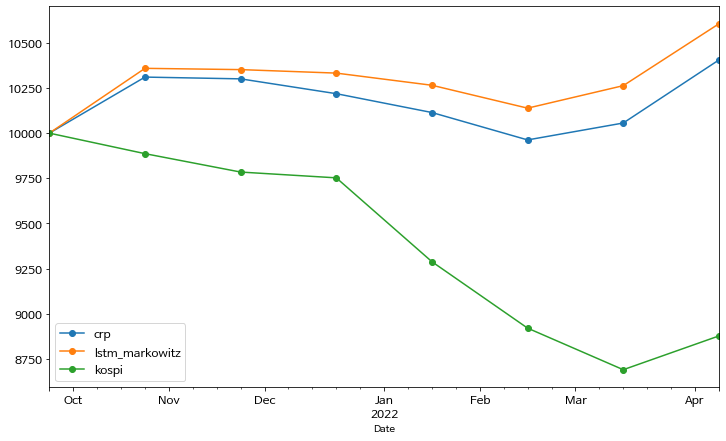

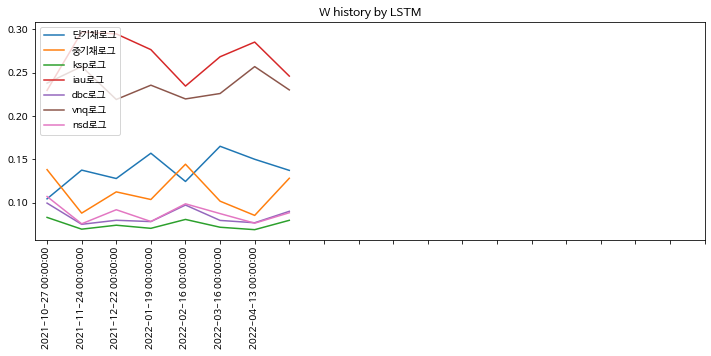


포트폴리오 수익률 (연간):
crp_rtn      0.068131
lstm_rtn     0.100836
sp500_rtn   -0.204279
dtype: float64

포트폴리오 위험 (연간):
crp_rtn      0.019841
lstm_rtn     0.019060
sp500_rtn    0.023718
dtype: float64

Sharp Ratio :
crp_rtn      3.433920
lstm_rtn     5.290482
sp500_rtn   -8.612955
dtype: float64


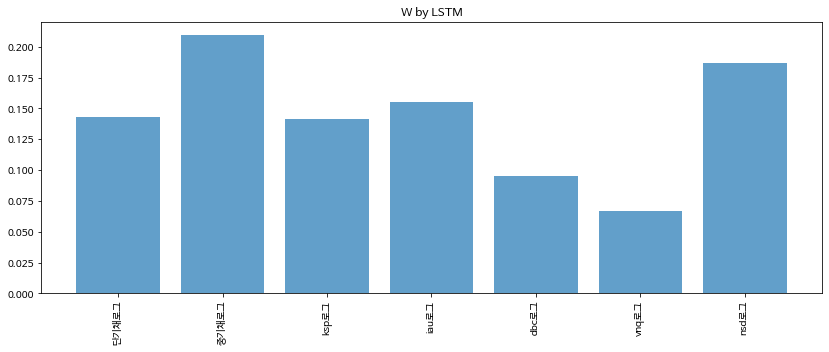

In [107]:
# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value[:8], 
                        'lstm_markowitz':lstm_value[:8]
                        }, 
                       index=test_date[idx])

# S&P500 index와 포트폴리오 성과를 비교해 본다.
sp500 = pd.DataFrame(df3['코스피'])

# 수익률을 계산해서 perf_df와 시작 위치를 맞춘다 (초기 value를 맞춘다).
sp500 = sp500[test_date[0]:]
sp_trans = lstm_value[0] / sp500['코스피'][0]
perf_df['kospi'] = sp500['코스피'] * sp_trans

# S&P500 index (시장), CRP, 그리고 MPN의 성과를 비교한다.
p = perf_df.plot(figsize=(12, 7), style = '-o', fontsize=12)
p.legend(fontsize=12)
plt.show()

# weights history를 확인한다.
w_hist_lstm = np.array(w_hist_lstm)

# 종목 이름을 읽어온다.
symbol = rtn_df.columns

n = 7
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.plot(w_hist_lstm[:, i], label=symbol[i])
plt.legend(loc='upper left')
plt.title('W history by LSTM')
plt.xticks(np.arange(0, 20), list(perf_df.index[1:]), rotation='vertical')
plt.show()

# 포트폴리오 수익률, 위험, SR을 측정한다.
rp_df = perf_df.copy()
rp_df['crp_rtn'] = np.log(rp_df['crp']) - np.log(rp_df['crp'].shift(1))
rp_df['lstm_rtn'] = np.log(rp_df['lstm_markowitz']) - np.log(rp_df['lstm_markowitz'].shift(1))
rp_df['sp500_rtn'] = np.log(rp_df['kospi']) - np.log(rp_df['kospi'].shift(1))
rp_df = rp_df.dropna()

# 포트폴리오 수익률 (연간)
rp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].mean()
# 20일 = 약 1개월, 1년 = 12개월
rp*=12
print('\n포트폴리오 수익률 (연간):')
print(rp)

# 포트폴리오 위험 (연간 표준편차)
sp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].std()
print('\n포트폴리오 위험 (연간):')
print(sp)

# Sharp ratio
print('\nSharp Ratio :')
print(rp / sp)

# 최적 포트폴리오 결과 확인용 코드 (참고용)
def check_w(n = 0):
    plt.figure(figsize=(14,5))
    x = xc_test[n][np.newaxis,:,:] * 20.0
    w_lstm = lstm_model.predict(x)[0]
    plt.bar(np.arange(N_STOCKS), w_lstm, alpha = 0.7)
    plt.xticks(np.arange(7), list(symbol), rotation='vertical')
    plt.title('W by LSTM')
    plt.show()
    
check_w(0)

In [108]:
perf_df

,crp,lstm_markowitz,kospi
Date,,,
2021-09-29,10000.000000,10000.000000,10000.000000
2021-10-27,10310.533712,10358.994007,9886.349802
2021-11-24,10300.712422,10351.932298,9784.398174
2021-12-22,10218.589872,10332.594173,9752.341988
2022-01-19,10114.197593,10265.198221,9287.677268
2022-02-16,9962.443141,10138.411163,8919.735560
2022-03-16,10056.164835,10263.072676,8689.527275
2022-04-13,10405.433940,10605.851342,8876.634980
